## [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing): ProPublica's Analysis of the COMPAS Tool

This workbook restates the initial data analysis tasks, per ProPublica's [methodology description](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) and [code](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb)

ProPublica's analysis was done in R, but we will do our same analysis in Python for the Lab

## Description

ProPublica analyzed 18,610 criminal defendants in Broward County, Florida and compared their predicted recidivism rates with the rate that actually occurred over a two-year period to determine if there was any bias.

## Importing Relevant Packages

In [2]:
import math

import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

### Acquiring the dataset, and understanding the data collection methodology.

Create a folder called "data" under the current folder, and download the COMPAS scores dataset.  The dataset is archived and is not expected to change.  Therefore, you can comment out this block if you already downloaded the data.

In [2]:
# Creates a folder "data" under the current folder
!mkdir -p data
# Removes any prior file if it exists
!rm -f data/compas-scores-two-years.csv*
# Fetches the most recent dataset and stores it under the folder data
!curl 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv' -o data/compas-scores-two-years.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2486k  100 2486k    0     0  3170k      0 --:--:-- --:--:-- --:--:-- 3175k


Inspect the file.  Read the description of the [data collection methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).  Salient points are highlighted below, with my annotations in **bold font**.  See full description from ProPublica for additional details.  

>**Goal**: We looked at more than 10,000 criminal defendants in Broward County, Florida, and compared their predicted recidivism rates with the rate that actually occurred over a two-year period.

>**COMPAS tool input (data subjects)**: When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of *Risk of Recidivism* and *Risk of Violent Recidivism*

>**How COMPAS input was acquired by ProPublica**: Through a public records request, ProPublica obtained two years worth of COMPAS scores from the Broward County Sheriff’s Office in Florida. We received data for all 18,610 people who were scored in 2013 and 2014.

>**COMPAS tool output**: Each pretrial defendant received at least three COMPAS scores: “Risk of Recidivism,” “Risk of Violence” and “Risk of Failure to Appear. ... COMPAS scores for each defendant ranged from 1 to 10, with ten being the highest risk. Scores 1 to 4 were labeled by COMPAS as “Low”; 5 to 7 were labeled “Medium”; and 8 to 10 were labeled “High.”

>**Data integration (record linkage) to matching COMPAS input and output with an individual's criminal history** Starting with the database of COMPAS scores, we built a profile of each person’s criminal history, both before and after they were scored. We collected public criminal records from the Broward County Clerk’s Office website through April 1, 2016. On average, defendants in our dataset were not incarcerated for 622.87 days (sd: 329.19).

>**Data integration (record linkage) details**: We matched the criminal records to the COMPAS records using a person’s first and last names and date of birth. This is the same technique used in the Broward County COMPAS validation study conducted by researchers at Florida State University in 2010. We downloaded around 80,000 criminal records from the Broward County Clerk’s Office website.

>**What is recidivism?**: Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored. ... **For most of our analysis, we defined recidivism as a new arrest within two years. **

# Part-1

# Risk of Recidivism

In [3]:
df_raw_data = pd.read_csv("data/compas-scores-two-years.csv")

In [4]:
df_raw_data.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [5]:
df_raw_data.shape

(7214, 53)

### Data profiling

Understand the statistical properties of the dataset.  

Here, we inspect the basic properties of the dataset: break-down by age, gender and race.

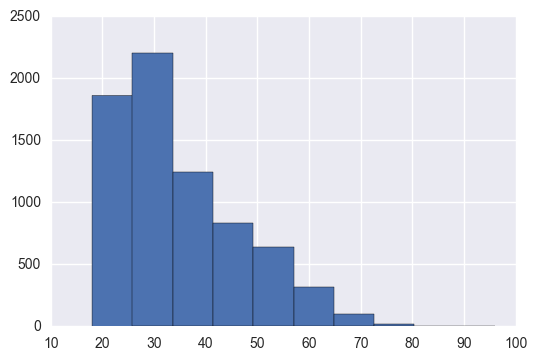

In [85]:
df_raw_data["age"].hist()

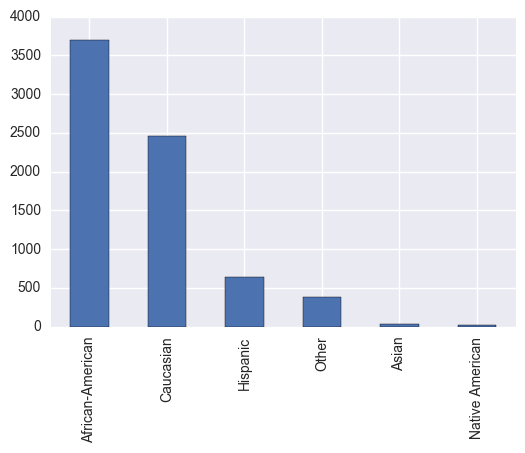

In [86]:
df_raw_data["race"].value_counts().plot(kind='bar')

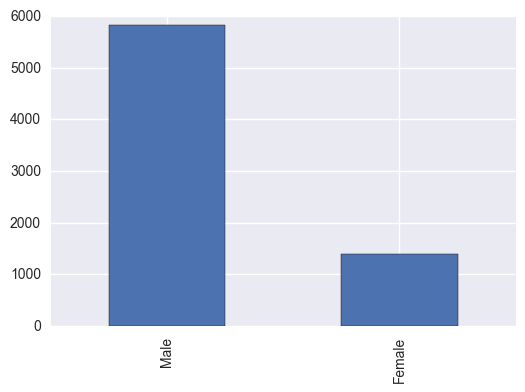

In [87]:
df_raw_data["sex"].value_counts().plot(kind='bar')

### Data cleaning

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.


## Columns of Interest:

1. `age` - Age of the defendant. It is numeric.
2. `age_cat` - Category of Age. It can be < 25, 25-45, >45.
3. `sex` - Sex of the defendant. It is either 'Male' or 'Female' 
4. `race` - Race of the defendant. It can be 'African-American', 'Caucasian', 'Hispanic', 'Asian', or 'Other'.
5. `c_charge_degree` - Degree of the crime. It is either M (Misdemeanor), F (Felony), or O (not causing jail time).
6. `priors_count` - Count of prior crimes committed by the defendant. It is numeric.
7. `days_b_screening_arrest` - Days between the arrest and COMPAS screening.
8. `decile_score` - The COMPAS score predicted by the system. It is between 0-10.
9. `score_text` - Category of decile score. It can be Low (1-4), Medium (5-7), and High (8-10).
10. `is_recid` - A variable to indicate if recidivism was done by the defendant. It can be 0, 1, -1.
11. `two_year_recid` - A variable to indicate if recidivism was done by the defendant within two years.
12. `c_jail_in` - Time when the defendant was jailed.
13. `c_jail_out` - Time when the defendant was released from the jail.

In [6]:
# projection: keep a subset of the columns in the original dataset

cols_to_keep = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in',
               'c_jail_out']

df1 = df_raw_data[cols_to_keep].copy()

print(df1.shape)

(7214, 13)


In [7]:
df1.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0,NaN,NaN
4,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0,NaN,NaN


In [8]:
# Condition 1 - remove petty traffic offenses that do not cause jail time
cond_1 = (df_raw_data.c_charge_degree != 'O')

# Condition 2 - remove rows which do not have a compas score
cond_2 = (df_raw_data.score_text != 'N/A') & (df_raw_data.is_recid != -1)

# Condition 3 - remove cases in which charge date is more than 30 days
cond_3 = (df_raw_data.days_b_screening_arrest <= 30) & (df_raw_data.days_b_screening_arrest >= -30)


df2 = df1[(cond_1 & cond_2 & cond_3)].copy()

print(df2.shape)

(6172, 13)


In [9]:
print('Original ', df_raw_data.shape)
print('Projected ', df1.shape)
print ('Cleaned ', df2.shape)

df2.head()

Original  (7214, 53)
Projected  (7214, 13)
Cleaned  (6172, 13)


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


### Data profiling, after data cleaning 

Look at basic properties of the dataset: break-down by age, gender and race.  Compare histograms before and after data cleaning.

Observe that we are going through the lifecycle **iteratively**: profile, clean, profile again.  

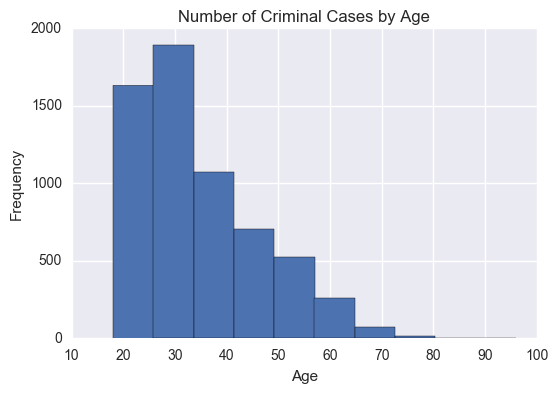

In [92]:
# visualize basic dataset statistics
df2["age"].hist()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Number of Criminal Cases by Age")

### Data exploration

Are there differences in the distribution of risk scores by gender or race?



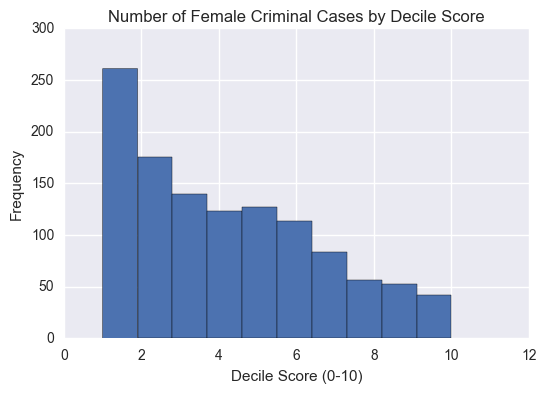

In [93]:
# compute score histograms by race and by gender 
df_f = df2[(df2.sex == 'Female')]
df_f["decile_score"].hist()
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Frequency")
plt.title("Number of Female Criminal Cases by Decile Score")

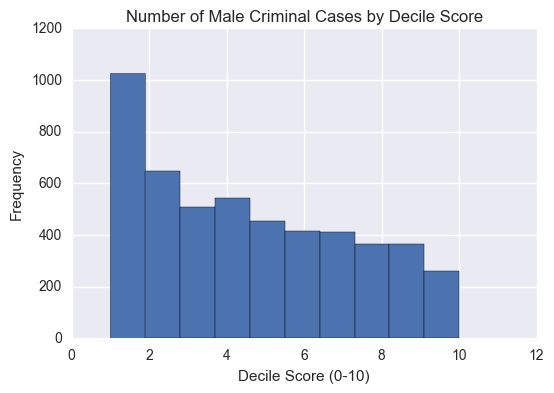

In [94]:
df_m = df2[(df2.sex == 'Male')]
df_m["decile_score"].hist()
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Frequency")
plt.title("Number of Male Criminal Cases by Decile Score")

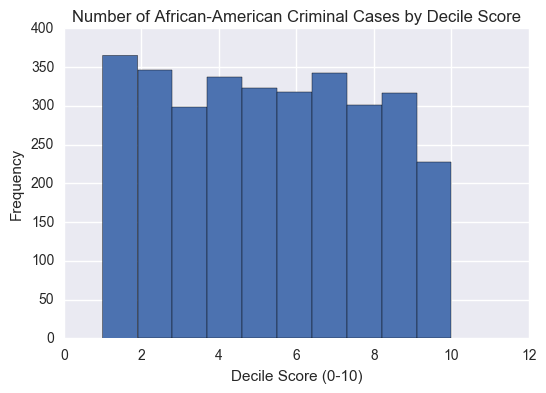

In [95]:
df_aa = df2[(df2.race == 'African-American')]
df_aa["decile_score"].hist()
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Frequency")
plt.title("Number of African-American Criminal Cases by Decile Score")

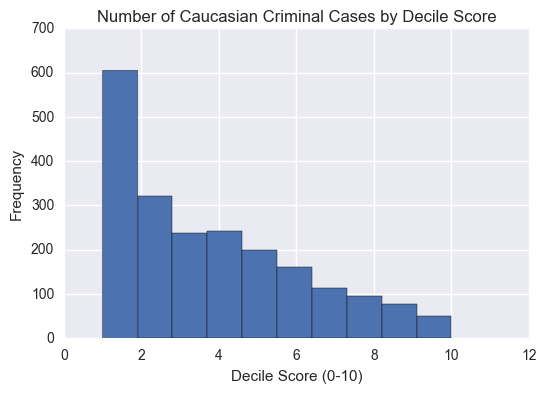

In [96]:
df_wh = df2[(df2.race == 'Caucasian')]
df_wh["decile_score"].hist()
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Frequency")
plt.title("Number of Caucasian Criminal Cases by Decile Score")

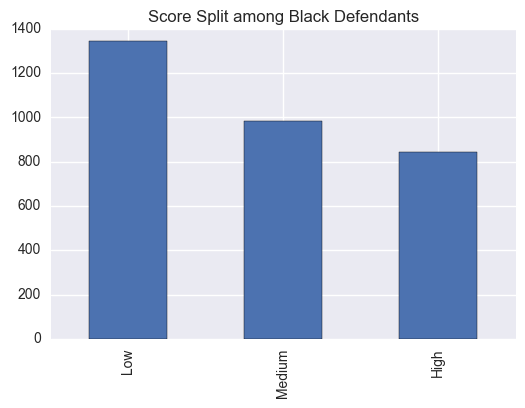

In [97]:
df_aa["score_text"].value_counts().plot(kind='bar', title = "Score Split among Black Defendants")

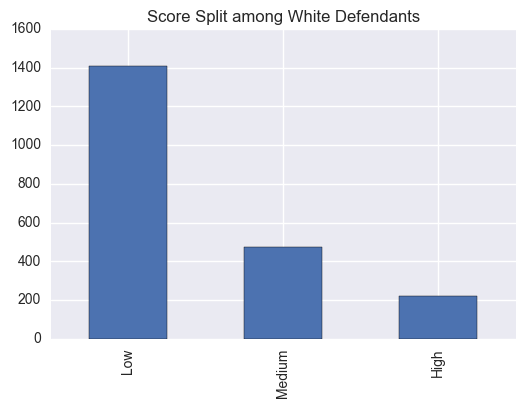

In [98]:
df_wh["score_text"].value_counts().plot(kind='bar', title = "Score Split among White Defendants")

In [99]:
df2['age_cat'].value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [100]:
df2['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

After filtering we have the following demographic breakdown:

In [101]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [102]:
df2['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [103]:
df2.pivot_table(values=['score_text'], columns=['race'], index=['sex'],aggfunc=lambda x: len(x))

score_text                                               
race   African-American Asian Caucasian Hispanic Native American Other
sex                                                                   
Female              549     2       482       82               2    58
Male               2626    29      1621      427               9   285

In [104]:
df2['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [105]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

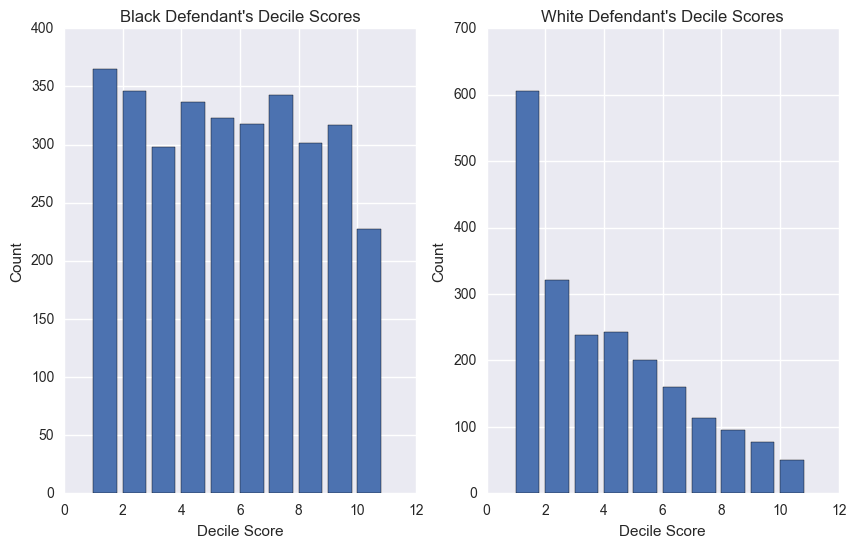

In [106]:
afr = df2[df2['race'] == "African-American"].groupby(df2['decile_score']).count()
cau = df2[df2['race'] == "Caucasian"].groupby(df2['decile_score']).count()

y_cau = list(cau['score_text'])
y_afr = list(afr['score_text'])
x = range(1,11)

fig = plt.figure(figsize=(10,6))
fig.add_subplot(121)
plt.bar(x, y_afr)
plt.xlabel('Decile Score')
plt.ylabel('Count')
plt.title("Black Defendant's Decile Scores")

fig.add_subplot(122)
plt.bar(x, y_cau)
plt.xlabel('Decile Score')
plt.ylabel('Count')
plt.title("White Defendant's Decile Scores")

# plt.tight_layout()
plt.show()

In [107]:
df2.pivot_table(values=['score_text'], columns=['race'], index=['decile_score'],aggfunc=lambda x: len(x))

score_text                                                
race         African-American Asian Caucasian Hispanic Native American  Other
decile_score                                                                 
1                       365.0  15.0     605.0    159.0             NaN  142.0
2                       346.0   4.0     321.0     89.0             2.0   60.0
3                       298.0   5.0     238.0     73.0             1.0   32.0
4                       337.0   NaN     243.0     47.0             NaN   39.0
5                       323.0   1.0     200.0     39.0             NaN   19.0
6                       318.0   2.0     160.0     27.0             2.0   20.0
7                       343.0   1.0     113.0     28.0             2.0    9.0
8                       301.0   2.0      96.0     14.0             NaN    7.0
9                       317.0   NaN      77.0     17.0             2.0    7.0
10                      227.0   1.0      50.0     16.0             2.0    8.0

## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into categorical variables and explode them using pandas dummies function, and run a logistic regression, comparing low scores to high scores.

Note: This is equivalent to applying factor to variables in R and then running a logistic regression.

The aim is to create a logistic regression model that predicts whether a defendant is of low risk vs high risk of recdivism, given attributes of the defendant.

After creating the model, we will look at the effects of the race, gender, and age variables while reducing the effect of confounding variables.  It means that when looking at the effect of one variable, the effects of all other variable predictors are taken into account by making the other variables take on a fixed value.

To recall, the logistic regression formula is given by:

$$y = \frac{e^{z}}{1+e^{z}}$$

where:

$y = $ probability of a defendant having a high risk of recidivism, <br />

$z = w^{T}X + w_0$ where: <br />
$w^{T}$ is the transposed matrix of the weights (co-efficients), <br />
$X$ is the matrix of the attributes, and <br />
$w_0$ is the intercept.

Alternatively, the formula can also be written as:

$$y = \frac{1}{1 + e^{-z}}$$ 

Before we proceed further, we will need to convert all our attributes to numeric as logistic regression takes only numeric attributes.

In [16]:
print(df2.dtypes)

age                          int64
c_charge_degree             object
race                        object
age_cat                     object
score_text                  object
sex                         object
priors_count                 int64
days_b_screening_arrest    float64
decile_score                 int64
is_recid                     int64
two_year_recid               int64
c_jail_in                   object
c_jail_out                  object
dtype: object


The attributes which are of dtype object are not numeric. Let us inspect what values they take.

In [18]:
print("Column c_charge_degree, which takes the following values:", df2['c_charge_degree'].unique())
print("Column race, which takes the following values:", df2['race'].unique())
print("Column age_cat, which takes the following values:", df2['age_cat'].unique())
print("Column sex, which takes the following values:", df2['sex'].unique())
print("Column score_text, which takes the following values:", df2['score_text'].unique())

Column c_charge_degree, which takes the following values: ['F' 'M']
Column race, which takes the following values: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']
Column age_cat, which takes the following values: ['Greater than 45' '25 - 45' 'Less than 25']
Column sex, which takes the following values: ['Male' 'Female']
Column score_text, which takes the following values: ['Low' 'Medium' 'High']


We convert the dtype of the above columns to category and then create dummy variables for each value of the variables.

In [19]:
df3 = df2.copy(deep=True)

df3['c_charge_degree'] = df3['c_charge_degree'].astype('category')
df3['age_cat'] = df3['age_cat'].astype('category')
df3['race'] = df3['race'].astype('category')
df3['sex'] = df3['sex'].astype('category')
df3['score_text'] = df3['score_text'].astype('category')

print(df3.dtypes)

age                           int64
c_charge_degree            category
race                       category
age_cat                    category
score_text                 category
sex                        category
priors_count                  int64
days_b_screening_arrest     float64
decile_score                  int64
is_recid                      int64
two_year_recid                int64
c_jail_in                    object
c_jail_out                   object
dtype: object


In [20]:
# explode c_charge_degree using get_dummies
dummies_c_charge_degree = pd.get_dummies(df3['c_charge_degree'])
df3 = pd.concat([df3, dummies_c_charge_degree], axis=1)
df3 = df3.drop(['c_charge_degree'], axis=1)

df3.head()

,age,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,F,M
0,69,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,1,0
1,34,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,1,0
2,24,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1,0
5,44,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,0,1
6,41,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,1,0


In [21]:
# age_cat
dummies_age_cat = pd.get_dummies(df3['age_cat'])
df3 = pd.concat([df3, dummies_age_cat], axis=1)

# Part of performing relevel after factor in R => Pro-Publica Analysis step
# dropping 25 - 45 as when < 25 = 0 and > 45 = 0, it automatically means 25 - 45 = 1
df3 = df3.drop(['age_cat', '25 - 45'], axis=1)

df3.head()

,age,race,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,F,M,Greater than 45,Less than 25
0,69,Other,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,1,0,1,0
1,34,African-American,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,1,0,0,0
2,24,African-American,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1,0,0,1
5,44,Other,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,0,1,0,0
6,41,Caucasian,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,1,0,0,0


In [22]:
# race
dummies_race = pd.get_dummies(df3['race'])
df3 = pd.concat([df3, dummies_race], axis=1)
df3 = df3.drop(['race', 'Caucasian'], axis=1)

df3.head()

,age,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,F,M,Greater than 45,Less than 25,African-American,Asian,Hispanic,Native American,Other
0,69,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,1,0,1,0,0,0,0,0,1
1,34,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,1,0,0,0,1,0,0,0,0
2,24,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1,0,0,1,1,0,0,0,0
5,44,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,0,1,0,0,0,0,0,0,1
6,41,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,1,0,0,0,0,0,0,0,0


In [23]:
# sex
dummies_sex = pd.get_dummies(df3['sex'])
df3 = pd.concat([df3, dummies_sex], axis=1)
df3 = df3.drop(['sex', 'Male'], axis=1)

df3.head()

,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,F,M,Greater than 45,Less than 25,African-American,Asian,Hispanic,Native American,Other,Female
0,69,Low,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,1,0,1,0,0,0,0,0,1,0
1,34,Low,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,1,0,0,0,1,0,0,0,0,0
2,24,Low,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1,0,0,1,1,0,0,0,0,0
5,44,Low,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,0,1,0,0,0,0,0,0,1,0
6,41,Medium,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,1,0,0,0,0,0,0,0,0,0


In [24]:
# Converting score_text to take binary values 
# Low = LowScore, Medium and High = HighScore

df3['score_text']= np.where(df3['score_text'] == "Low", "LowScore", df3['score_text'])

df3['score_text']= np.where(df3['score_text'] != "LowScore", "HighScore", df3['score_text'])

df3['score_text'] = df3['score_text'].astype('category')

df3.score_text.value_counts()

LowScore     3421
HighScore    2751
Name: score_text, dtype: int64

We rename the columns because the statsmodel does not like spaces in the variable names.

In [25]:
renamed_cols = {'African-American':'African_American', 'Greater than 45':'Greater_than_45', 
                'Less than 25':'Less_than_25', 'Native American':'Native_American', 'F': 'Felony',
               'M': 'Misdemeanor'}

df3 = df3.rename(columns=renamed_cols)

In [141]:
df3.dtypes

age                           int64
score_text                 category
priors_count                  int64
days_b_screening_arrest     float64
decile_score                  int64
is_recid                      int64
two_year_recid                int64
c_jail_in                    object
c_jail_out                   object
Felony                        uint8
Misdemeanor                   uint8
Greater_than_45               uint8
Less_than_25                  uint8
African_American              uint8
Asian                         uint8
Hispanic                      uint8
Native_American               uint8
Other                         uint8
Female                        uint8
dtype: object

In [142]:
df3.shape

(6172, 19)

In [143]:
df3.head()

,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,Felony,Misdemeanor,Greater_than_45,Less_than_25,African_American,Asian,Hispanic,Native_American,Other,Female
0,69,LowScore,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,1,0,1,0,0,0,0,0,1,0
1,34,LowScore,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,1,0,0,0,1,0,0,0,0,0
2,24,LowScore,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1,0,0,1,1,0,0,0,0,0
5,44,LowScore,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,0,1,0,0,0,0,0,0,1,0
6,41,HighScore,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,1,0,0,0,0,0,0,0,0,0


In [27]:
attributes = 'priors_count + two_year_recid + Misdemeanor + Greater_than_45 + Less_than_25 + \
African_American + Asian + Hispanic + Native_American + Other + Female'

target = 'score_text'

In [28]:
formula = target + ' ~ ' + attributes

print(formula)

score_text ~ priors_count + two_year_recid + Misdemeanor + Greater_than_45 + Less_than_25 + African_American + Asian + Hispanic + Native_American + Other + Female


In [29]:
model = sm.formula.glm(formula=formula, family=sm.families.Binomial(), data = df3).fit()

print(model.summary())

                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['score_text[HighScore]', 'score_text[LowScore]']   No. Observations:                 6172
Model:                                                           GLM   Df Residuals:                     6160
Model Family:                                               Binomial   Df Model:                           11
Link Function:                                                 logit   Scale:                             1.0
Method:                                                         IRLS   Log-Likelihood:                -3084.2
Date:                                               Fri, 01 Feb 2019   Deviance:                       6168.4
Time:                                                       07:58:28   Pearson chi2:                 6.07e+03
No. Iterations:                                                    6                                         
          

From the above table, we see a great overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures.

To compare the odds of two variables happening, we get the odds ratio of those two variables.

Mathematically, this would be:

$$\ln{(\frac{y}{1-y})} = w_0 + w_1 x_1$$

where: <br />
$x_1$ = Female (say), then -> when $x_1 = 1$, it's Female, when $x_1 = 0$, it's Male <br />

Therefore,

$w_0 + w_1$ = **log odds** of high recividism for Female defendants, <br />
$w_0$ = **log odds** of high recividism for Male defendants


To get the odds (and not the log odds), we transform the above equation to get:

$e^{w_0 + w_1}$ = **odds** of high recividism for Female defendants, <br />
$e^{w_0}$ = **odds** of high recividism for Male defendants, <br />

To get the odd ratio, we divide the two odds to compare them.

To compare age and race variables, it is the same procedure. <br />

**In the case of age** <br />
$x_1$ = Less_than_25 <br />
then -> when $x_1 = 1$, the age is less than 25, when $x_1 = 0$, the age is between 25 - 45 <br />

Therefore, <br />
$e^{w_0 + w_1}$ = **odds** of high recividism for defendants whose age is less than 25, <br />
$e^{w_0}$ = **odds** of high recividism for defendants whose age is between 25 - 45 <br />

**In the case of race**  <br />
$x_1$ = African-American <br />
then -> when $x_1 = 1$, the defendant is an African-American, when $x_1 = 0$, the defendant is a Caucasian <br />

Therefore, <br />
$e^{w_0 + w_1}$ = **odds** of high recividism for an African-American defendant, <br />
$e^{w_0}$ = **odds** of high recividism for a Caucasian defendant <br />

## Comparing the odds

## African-American vs Caucasian

In [30]:
af_am_odds = np.exp(-1.5255+0.4772)
cau_odds = np.exp(-1.5255)

race_odd_ratio = af_am_odds / cau_odds

print("Odd Ratio:", race_odd_ratio)

Odd Ratio: 1.61155572297


This means that the **odds of high recividism** is about **`1.6 times greater`** for an **African-American** defendant than a **Caucasian** defendant (when all the other variables are controlled for). 

## Women vs Men

In [33]:
women_odds = np.exp(-1.5255+0.22127)
men_odds = np.exp(-1.5255)

sex_odd_ratio = women_odds / men_odds

print("Odd Ratio:", sex_odd_ratio)

Odd Ratio: 1.24766025336


This means that the **odds of high recividism** is about **`1.25 times greater`** for a **Female** defendant than a **Male** defendant (when all the other variables are controlled for).

## Young vs Middle-Aged

In [34]:
young_odds = np.exp(-1.5255+1.30839)
middle_odds = np.exp(-1.5255)

age_odd_ratio = young_odds / middle_odds

print("Odd Ratio:", age_odd_ratio)

Odd Ratio: 3.70021157334


This means that the **odds of high recividism** is about **`3.7 times greater`** for a **Young** defendant than a **Middle-Aged** defendant (when all the other variables are controlled for).

## Comparing the Relative Risks (R.R)

Odd ratios are useful to compare events with nonevents (Cancer or No Cancer). It also has a tendency to over-estimate. Looking at the relative-risk (RR) of probabilities would be more helpful in our case as it compares the likelihood of an event in relation to all possible events (High Risk, Low Risk).

Relative Risk is a ratio of probabilities. The formula is given by:


$A = P(C= 1 | x_1 = 1) = \frac{e^{w_0 + w_1}}{1 + e^{w_0 + w_1}}$ <br />

where: <br />
$C$ = 1 (High Recividism) <br />
$x_1$ = 1 (Female) (say) <br />

and <br />

$B = P(C= 1 | x_1 = 0) = \frac{e^{w_0}}{1 + e^{w_0}}$ <br />

where: <br />
$C$ = 1 (High Recividism) <br />
$x_1$ = 0 (Male) (say) <br />

Then, <br />
R.R for a given variable (say Female) = $\frac{A}{B}$

We call B the control variable. It is the same for all the three variables, age, gender, and race. So let us define it here.

In [35]:
control_prob = math.exp(-1.52554) / (1 + math.exp(-1.52554))

## African-American vs Caucasian

In [38]:
af_am_prob = (np.exp(-1.5255+0.4772)/(1+np.exp(-1.5255+0.4772)))

race_rr = af_am_prob/control_prob

print("Relative Risk:", race_rr)

Relative Risk: 1.45287313891


Since the relative risk (the ratio of probabilities) is greater than 1, this indicates that if the defendant is Black, he is **`45% more likely`** to receive a higher score than a defendant who is White, when other variables such as seriousness of their crime, previous arrests, and future criminal behavior is corrected (or controlled).

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

## Women vs Men

In [40]:
women_prob = ( np.exp(-1.5255+0.22127) / (1 + np.exp(-1.5255+0.22127) ) ) 

sex_rr = women_prob / control_prob

print("Relative Risk:", sex_rr)

Relative Risk: 1.19483544214


Since the relative risk (the ratio of probabilities) is greater than 1, this indicates that if the defendant is a **woman**, she is **`19.4% more likely`** to receive a higher score than a defendant who is a **man**, when other variables such as seriousness of their crime, previous arrests, and future criminal behavior is corrected (or controlled).

## Young vs Middle-Aged

In [41]:
young_prob = ( np.exp(-1.5255+1.30839) / (1 + np.exp(-1.5255+1.30839) ) ) 

age_rr = young_prob / control_prob

print("Relative Risk:", age_rr)

Relative Risk: 2.49617552937


Since the relative risk (the ratio of probabilities) is greater than 1, this indicates that if the defendant is **young**, he/she is **`150% more likely`** to receive a higher score than a defendant who is **middle-aged**, when other variables such as seriousness of their crime, previous arrests, and future criminal behavior is corrected (or controlled).

Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

## Conclusion

This analysis is done to show how bias can creep in when creating a model and how we should be able to determine the bias before deploying our model for production.

We should keep in mind that if our end goal was to actually develop a model with good predictive capability, we would not fit the model on the entire dataset. Instead, we would divide out dataset into training and testing and run cross-validation to get the best hyperparameters for that model.

If we were to compare two such models, we would further conduct a hypothesis test to decide which model is better.

Also, sometimes, the heavily trained and tested model does a good job at predicting the target variable (for example, revenue) but that would come at the cost/expense of biases such as race, gender, or age. So we should still find out such biases even if our model has a high accuracy/f-1 score/recall/precision.

# Part-2

# Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [70]:
df_raw_violent_data = pd.read_csv('https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years-violent.csv')
df_raw_violent_data.shape


(4743, 54)

In [71]:
df_raw_violent_data.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


Just like before, let's do some Data Profiling before we move to Data Cleaning step

#### Data Profiling

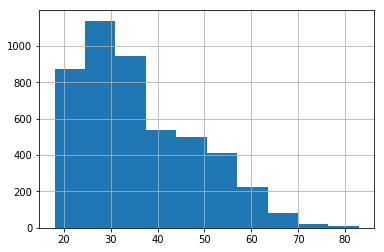

In [72]:
df_raw_violent_data["age"].hist()

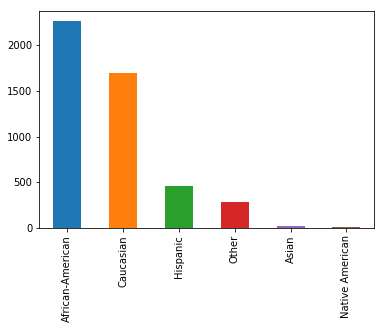

In [73]:
df_raw_violent_data["race"].value_counts().plot(kind='bar')

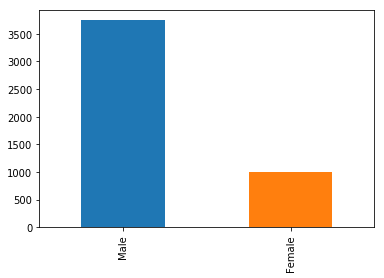

In [74]:
df_raw_violent_data["sex"].value_counts().plot(kind='bar')

#### Data Cleaning

In [75]:
# projection: keep a subset of the columns in the original dataset
df1_violent = df_raw_violent_data[['age', 'c_charge_degree', 'race', 'age_cat', 'v_score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'v_decile_score', 'is_recid', 'two_year_recid']]

print(df1_violent.shape)

(4743, 11)


In [77]:
# clean the data per ProPublica's methodology
df2_violent = df1_violent[(df.c_charge_degree != 'O') & (df.v_score_text != 'N/A') & (df.is_recid != -1)
               & (df.days_b_screening_arrest <= 30) & (df.days_b_screening_arrest >= -30)]

df2_violent.shape


(4020, 11)

In [78]:
print('Original ', len(df_raw_violent_data))
print('Projected ', len(df1_violent))
print ('Cleaned ', len(df2_violent))
df2.head()

Original  4743
Projected  4743
Cleaned  4020


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


#### Data Exploration

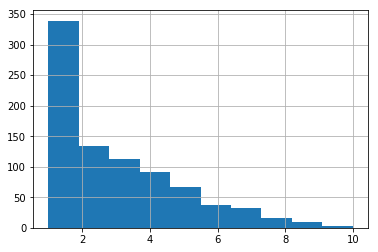

In [79]:
# compute score histograms by race and by gender 
df_f_violent = df2_violent[(df2_violent.sex == 'Female')]
df_f_violent["v_decile_score"].hist()

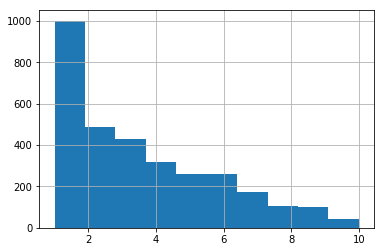

In [80]:
df_m_violent = df2_violent[(df2_violent.sex == 'Male')]
df_m_violent["v_decile_score"].hist()


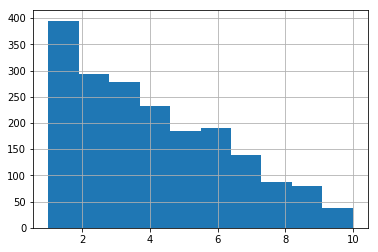

In [81]:
df_aa_violent = df2_violent[(df2_violent.race == 'African-American')]
df_aa_violent["v_decile_score"].hist()

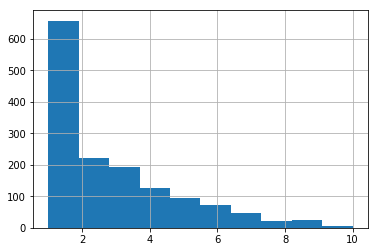

In [82]:
df_wh_violent = df2_violent[(df2_violent.race == 'Caucasian')]
df_wh_violent["v_decile_score"].hist()

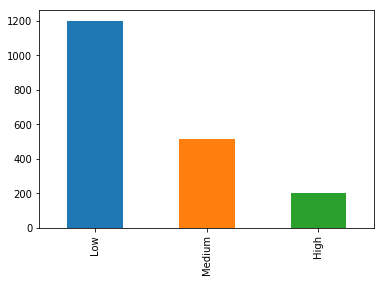

In [83]:
df_aa_violent["v_score_text"].value_counts().plot(kind='bar')

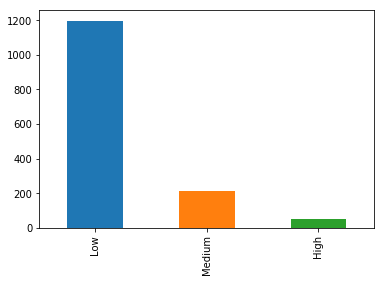

In [84]:
df_wh_violent["v_score_text"].value_counts().plot(kind='bar')

In [85]:
df2_violent['age_cat'].value_counts()

25 - 45            2300
Greater than 45     954
Less than 25        766
Name: age_cat, dtype: int64

In [86]:
df2_violent['race'].value_counts()

African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: race, dtype: int64

After filtering we have the following demographic breakdown:

In [87]:
print("Black defendants: %.2f%%" %            (1918 / 4020 * 100))
print("White defendants: %.2f%%" %            (1459 / 4020 * 100))
print("Hispanic defendants: %.2f%%" %         (355  / 4020 * 100))
print("Asian defendants: %.2f%%" %            (26   / 4020 * 100))
print("Native American defendants: %.2f%%" %  (7   / 4020 * 100))

Black defendants: 47.71%
White defendants: 36.29%
Hispanic defendants: 8.83%
Asian defendants: 0.65%
Native American defendants: 0.17%


In [89]:
df2_violent['v_score_text'].value_counts()

Low       2913
Medium     828
High       279
Name: v_score_text, dtype: int64

In [90]:
df2_violent.pivot_table(values=['v_score_text'], columns=['race'], index=['sex'],aggfunc=lambda x: len(x))

v_score_text                                                
race   African-American Asian Caucasian Hispanic Native American  Other
sex                                                                    
Female            393.0   1.0     336.0     61.0             NaN   50.0
Male             1525.0  25.0    1123.0    294.0             7.0  205.0

In [92]:
df2_violent['sex'].value_counts()

Male      3179
Female     841
Name: sex, dtype: int64

In [93]:
print("Men: %.2f%%" %   (3179 / 4020 * 100))
print("Women: %.2f%%" % (841 / 6172 * 100))

Men: 79.08%
Women: 13.63%


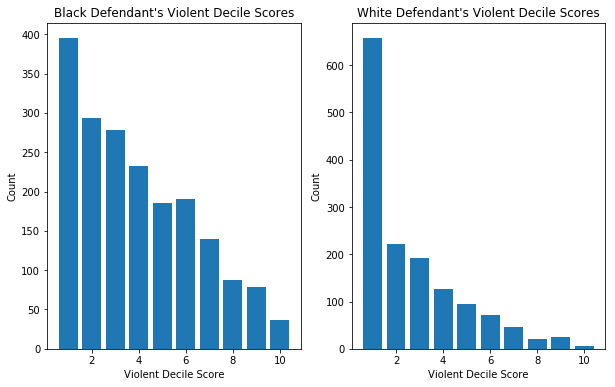

In [95]:
afr_violent = df2_violent[df2_violent['race'] == "African-American"].groupby(df2_violent['v_decile_score']).count()
cau_violent = df2_violent[df2_violent['race'] == "Caucasian"].groupby(df2_violent['v_decile_score']).count()

y_cau_violent = list(cau_violent['v_score_text'])
y_afr_violent = list(afr_violent['v_score_text'])
x = range(1,11)

fig = plt.figure(figsize=(10,6))
fig.add_subplot(121)
plt.bar(x, y_afr_violent)
plt.xlabel('Violent Decile Score')
plt.ylabel('Count')
plt.title("Black Defendant's Violent Decile Scores")

fig.add_subplot(122)
plt.bar(x, y_cau_violent)
plt.xlabel('Violent Decile Score')
plt.ylabel('Count')
plt.title("White Defendant's Violent Decile Scores")

# plt.tight_layout()
plt.show()

In [96]:
df3_violent = df2_violent.copy(deep=True)

df3_violent['c_charge_degree'] = df3_violent['c_charge_degree'].astype('category')
df3_violent['age_cat'] = df3_violent['age_cat'].astype('category')
df3_violent['race'] = df3_violent['race'].astype('category')
df3_violent['sex'] = df3_violent['sex'].astype('category')
df3_violent['v_score_text'] = df3_violent['v_score_text'].astype('category')

print(df3_violent.dtypes)

age                           int64
c_charge_degree            category
race                       category
age_cat                    category
v_score_text               category
sex                        category
priors_count                  int64
days_b_screening_arrest     float64
v_decile_score                int64
is_recid                      int64
two_year_recid                int64
dtype: object


In [97]:
# explode c_charge_degree using get_dummies
dummies_c_charge_degree = pd.get_dummies(df3_violent['c_charge_degree'])
df3_violent = pd.concat([df3_violent, dummies_c_charge_degree], axis=1)
df3_violent = df3_violent.drop(['c_charge_degree'], axis=1)

# age_cat
dummies_age_cat = pd.get_dummies(df3_violent['age_cat'])
df3_violent = pd.concat([df3_violent, dummies_age_cat], axis=1)

# Part of performing relevel after factor in R => Pro-Publica Analysis step
df3_violent = df3_violent.drop(['age_cat', '25 - 45'], axis=1)

# race
dummies_race = pd.get_dummies(df3_violent['race'])
df3_violent = pd.concat([df3_violent, dummies_race], axis=1)
df3_violent = df3_violent.drop(['race', 'Caucasian'], axis=1)

# sex
dummies_sex = pd.get_dummies(df3_violent['sex'])
df3_violent = pd.concat([df3_violent, dummies_sex], axis=1)
df3_violent = df3_violent.drop(['sex', 'Male'], axis=1)


df3_violent['v_score_text']= np.where(df3_violent['v_score_text'] == "Low", "LowScore", df3_violent['v_score_text'])

df3_violent['v_score_text']= np.where(df3_violent['v_score_text'] != "LowScore", "HighScore", df3_violent['v_score_text'])

df3_violent['v_score_text'] = df3_violent['v_score_text'].astype('category')


In [98]:
df3_violent = df3_violent.rename(columns={'African-American':'African_American', 'Greater than 45':'Greater_than_45', 'Less than 25':'Less_than_25', 'Native American':'Native_American'})


In [99]:
df3_violent.dtypes

age                           int64
v_score_text               category
priors_count                  int64
days_b_screening_arrest     float64
v_decile_score                int64
is_recid                      int64
two_year_recid                int64
F                             uint8
M                             uint8
Greater_than_45               uint8
Less_than_25                  uint8
African_American              uint8
Asian                         uint8
Hispanic                      uint8
Native_American               uint8
Other                         uint8
Female                        uint8
dtype: object

In [100]:
df3_violent.shape

(4020, 17)

In [101]:
df3_violent.head(5)

,age,v_score_text,priors_count,days_b_screening_arrest,v_decile_score,is_recid,two_year_recid,F,M,Greater_than_45,Less_than_25,African_American,Asian,Hispanic,Native_American,Other,Female
0,69,LowScore,0,-1.0,1,0,0,1,0,1,0,0,0,0,0,1,0
1,34,LowScore,0,-1.0,1,1,1,1,0,0,0,1,0,0,0,0,0
4,44,LowScore,0,0.0,1,0,0,0,1,0,0,0,0,0,0,1,0
5,43,LowScore,3,-1.0,3,0,0,1,0,0,0,0,0,0,0,1,0
6,39,LowScore,0,-1.0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [102]:
attributes = ['priors_count', 'two_year_recid', 'M', 'Greater_than_45',
       'Less_than_25', 'African_American', 'Asian', 'Hispanic',
       'Native_American', 'Other', 'Female']
target = ['v_score_text']

In [103]:
model_violent = sm.formula.glm('v_score_text ~ priors_count + two_year_recid + M + Greater_than_45 + Less_than_25 + African_American + Asian + Hispanic + Native_American + Other + Female'
    , family=sm.families.Binomial(), data = df3_violent).fit()
print(model_violent.summary())


                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['v_score_text[HighScore]', 'v_score_text[LowScore]']   No. Observations:                 4020
Model:                                                               GLM   Df Residuals:                     4008
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -1499.4
Date:                                                   Sun, 27 Jan 2019   Deviance:                       2998.8
Time:                                                           02:36:20   Pearson chi2:                 3.83e+03
No. Iterations:                                                        6   Covariance Ty

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [105]:
control = math.exp(-2.24274) / (1 + math.exp(-2.24274))
math.exp(0.65893) / (1 - control + (control * math.exp(0.65893)))

1.7739209589164604

Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [106]:
math.exp(3.14591) / (1 - control + (control * math.exp(3.14591)))

7.414239863565466